In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Call Dataset Folder Path**

In [ ]:
import os
os.getcwd()
path=%cd /content/drive/MyDrive/Alzheimer_Detect

/content/drive/MyDrive/Alzheimer_Detect


**Data Augmentation and Preprocessig**

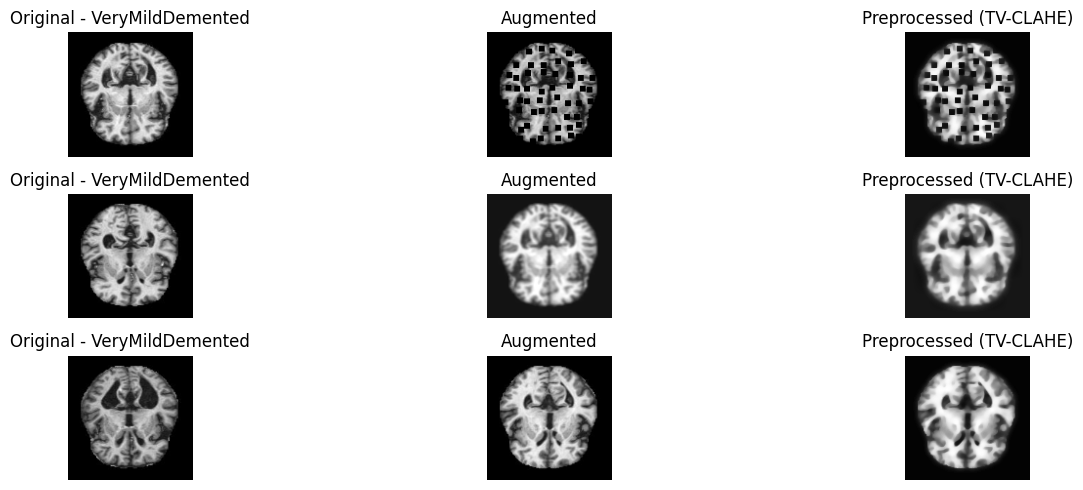

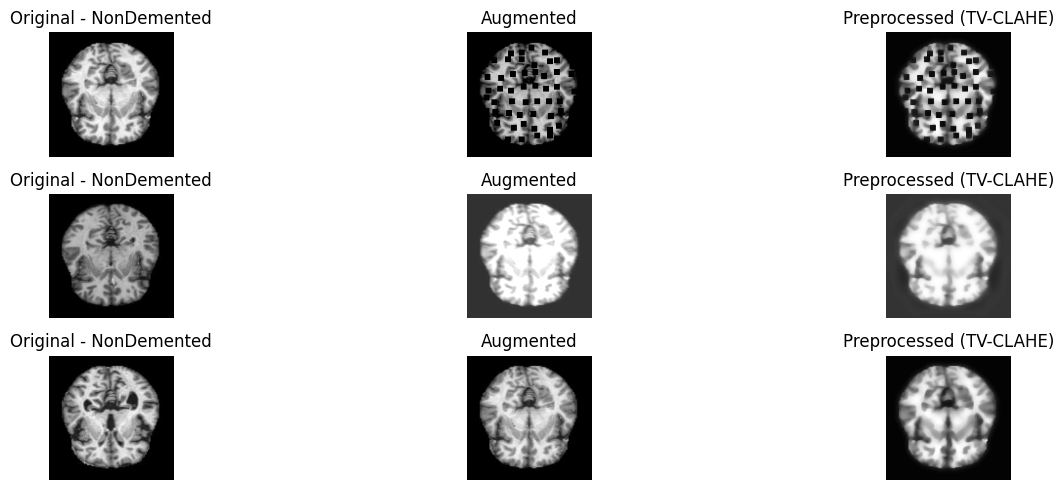

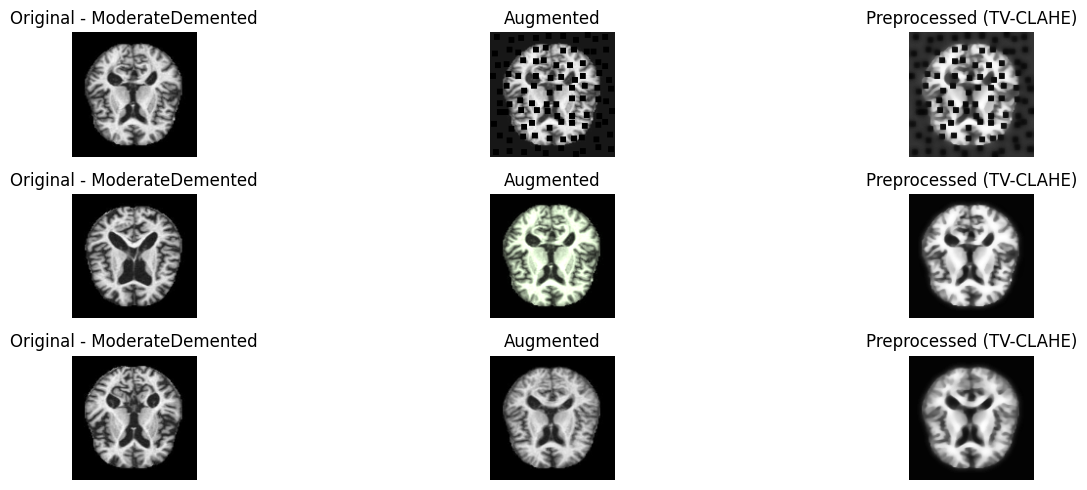

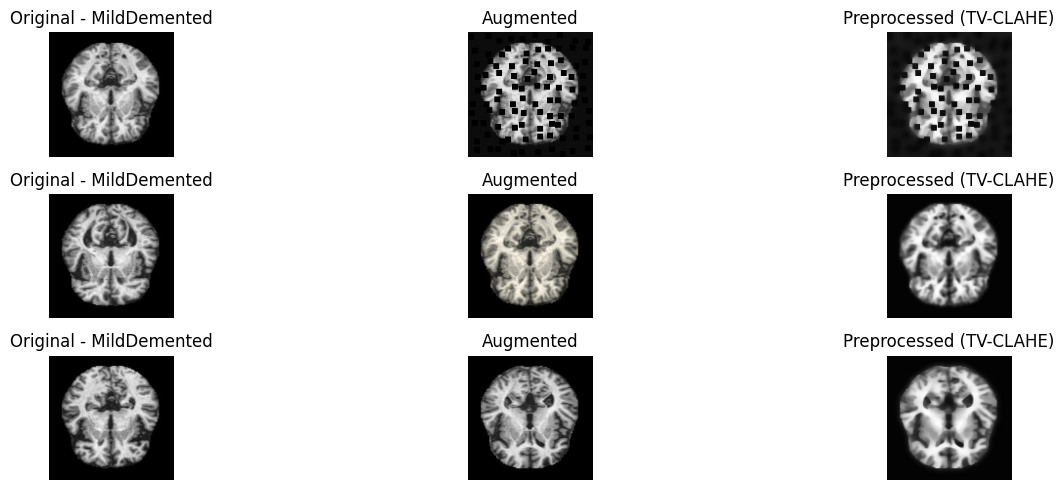

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.restoration import denoise_tv_chambolle
import albumentations as A

# ============================
# Paths & Params
# ============================
data_dir = "/content/drive/My Drive/Alzheimer_Detect/Dataset3"
img_size = 128
categories = os.listdir(data_dir)
print("Classes:", categories)

# ============================
# Augmentations
# ============================
albumentations_aug = A.Compose([
    A.ColorJitter(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDropout(ratio=0.5, random_offset=True, p=0.5)
])

augmix_aug = A.Compose([
    A.OneOf([
        A.Blur(blur_limit=3, p=0.3),
        A.MotionBlur(p=0.3),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=0.3)
    ], p=1.0),
    A.RandomBrightnessContrast(p=0.5),
])

# ============================
# MixUp & CutMix
# ============================
def mixup(img1, img2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    mixed = (lam * img1 + (1 - lam) * img2).astype(np.uint8)
    return mixed

def cutmix(img1, img2):
    h, w, _ = img1.shape
    cx, cy = np.random.randint(w), np.random.randint(h)
    cut_w, cut_h = w // 2, h // 2
    x1, y1 = np.clip(cx - cut_w // 2, 0, w), np.clip(cy - cut_h // 2, 0, h)
    x2, y2 = np.clip(cx + cut_w // 2, 0, w), np.clip(cy + cut_h // 2, 0, h)
    img1[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
    return img1

# ============================
# Enhancement: TV-CLAHE
# ============================
def enhance_tv_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    tv_denoised = denoise_tv_chambolle(gray, weight=0.1)
    tv_denoised = (tv_denoised * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(tv_denoised)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

# ============================
# Data Pipeline
# ============================
original_data, augmented_data, preprocessed_data = [], [], []
orig_labels, aug_labels, preproc_labels = [], [], []

for class_index, category in enumerate(categories):
    class_path = os.path.join(data_dir, category)
    images = os.listdir(class_path)
    print(f"Class {category}: Found {len(images)} images")

    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))

        # ------------------------------
        # Original
        # ------------------------------
        original_data.append(img)
        orig_labels.append(class_index)

        # ------------------------------
        # Augmentations
        # ------------------------------
        aug1 = albumentations_aug(image=img)['image']
        aug2 = augmix_aug(image=img)['image']
        # import warnings
        # warnings.filterwarnings("ignore", category=UserWarning, module="albumentations")
        rand_img_name = random.choice(images)
        rand_img = cv2.imread(os.path.join(class_path, rand_img_name))
        if rand_img is None:
            continue
        rand_img = cv2.resize(rand_img, (img_size, img_size))

        aug3 = mixup(img, rand_img)
        aug4 = cutmix(img.copy(), rand_img.copy())

        augmented_data.extend([aug1, aug2, aug3, aug4])
        aug_labels.extend([class_index] * 4)

        # ------------------------------
        # Preprocessing (TV-CLAHE)
        # ------------------------------
        preproc_imgs = [enhance_tv_clahe(a) for a in [aug1, aug2, aug3, aug4]]
        preprocessed_data.extend(preproc_imgs)
        preproc_labels.extend([class_index] * 4)

print(f"\nOriginals: {len(original_data)}, Augments: {len(augmented_data)}, Preprocessed: {len(preprocessed_data)}")

# ============================
# Visualization Helper
# ============================
def show_images_per_class(originals, augments, preprocesseds, orig_labels, aug_labels, preproc_labels, classes, n=3):
    """
    Show n examples per class (Original, Augmented, Preprocessed).
    """
    for cls_idx, cls_name in enumerate(classes):
        # Pick n indices for each dataset
        orig_idx = [i for i, l in enumerate(orig_labels) if l == cls_idx][:n]
        aug_idx = [i for i, l in enumerate(aug_labels) if l == cls_idx][:n]
        pre_idx = [i for i, l in enumerate(preproc_labels) if l == cls_idx][:n]

        plt.figure(figsize=(15, 5))
        for j in range(n):
            # Original
            if j < len(orig_idx):
                plt.subplot(n, 3, j*3 + 1)
                plt.imshow(cv2.cvtColor(originals[orig_idx[j]], cv2.COLOR_BGR2RGB))
                plt.title(f"Original - {cls_name}")
                plt.axis("off")

            # Augmented
            if j < len(aug_idx):
                plt.subplot(n, 3, j*3 + 2)
                plt.imshow(cv2.cvtColor(augments[aug_idx[j]], cv2.COLOR_BGR2RGB))
                plt.title("Augmented")
                plt.axis("off")

            # Preprocessed
            if j < len(pre_idx):
                plt.subplot(n, 3, j*3 + 3)
                plt.imshow(cv2.cvtColor(preprocesseds[pre_idx[j]], cv2.COLOR_BGR2RGB))
                plt.title("Preprocessed (TV-CLAHE)")
                plt.axis("off")

        plt.tight_layout()
        plt.show()

# Example visualization
show_images_per_class(original_data, augmented_data, preprocessed_data,
                      orig_labels, aug_labels, preproc_labels,
                      categories, n=3)


In [ ]:
print("Number of original images:", len(original_data))
print("Number of preprocessed images:", len(preprocessed_data))

if len(original_data) > 0:
    print("Shape of one original image:", np.array(original_data[0]).shape)

if len(preprocessed_data) > 0:
    print("Shape of one preprocessed image:", np.array(preprocessed_data[0]).shape)


Number of original images: 834
Number of preprocessed images: 3336
Shape of one original image: (128, 128, 3)
Shape of one preprocessed image: (128, 128, 3)


**Feature Extraction Phase**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# ---------- Residual conv block ----------
def conv_residual_block(x, filters, kernel_size=3, stride=1, name=None):
    """Residual block: Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU"""
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False,
                      kernel_initializer='he_normal', name=None if name is None else name + "_conv1")(x)
    x = layers.BatchNormalization(name=None if name is None else name + "_bn1")(x)
    x = layers.Activation("relu", name=None if name is None else name + "_act1")(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False,
                      kernel_initializer='he_normal', name=None if name is None else name + "_conv2")(x)
    x = layers.BatchNormalization(name=None if name is None else name + "_bn2")(x)

    # shortcut projection if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False,
                                 kernel_initializer='he_normal', name=None if name is None else name + "_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=None if name is None else name + "_proj_bn")(shortcut)

    x = layers.Add(name=None if name is None else name + "_add")([x, shortcut])
    x = layers.Activation("relu", name=None if name is None else name + "_out")(x)
    return x


# ---------- Build ECRB ----------
def build_ecrb(
    patch_size=64,         # 🔹 smaller input size
    clinical_dim=10,
    feature_dim=32,        # 🔹 smaller feature dimension
    bn_backbone_trainable=False,
    dropout_rate=0.3,
):
    """
    ECRB multi-modal extractor with grayscale input and 32-dim fused features
    """
    # Image branch (grayscale input)
    img_in = layers.Input(shape=(patch_size, patch_size, 1), name="image_patch")

    # Convert grayscale -> 3 channels for EfficientNet
    x = layers.Concatenate(axis=-1)([img_in, img_in, img_in])

    # Resize to EfficientNetB3 expected input size (300x300)
    x = layers.Resizing(300, 300, name="resize_to_300")(x)
    x = layers.Lambda(preprocess_input, name="preprocess")(x)

    # EfficientNetB3 backbone
    backbone = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=x, pooling=None)
    for layer in backbone.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = bn_backbone_trainable

    feat = backbone.output

    # Residual blocks with smaller filters
    filters_seq = [64, 64, 128]
    for i, f in enumerate(filters_seq):
        feat = conv_residual_block(feat, f, kernel_size=3, stride=1, name=f"ecrb_res{i}")

    # Global pooling -> feature vector
    feat = layers.GlobalAveragePooling2D(name="gap")(feat)
    feat = layers.Dense(128, activation="relu", name="img_fc1")(feat)
    feat = layers.BatchNormalization(name="img_bn")(feat)
    feat = layers.Dropout(dropout_rate, name="img_dropout")(feat)
    img_feature = layers.Dense(feature_dim, activation=None, name="img_feature")(feat)  # 32-dim

    # Clinical branch
    clin_in = layers.Input(shape=(clinical_dim,), name="clinical_input")
    c = layers.Dense(32, activation="relu", name="clin_fc1")(clin_in)
    c = layers.BatchNormalization(name="clin_bn1")(c)
    c = layers.Dropout(0.2, name="clin_drop1")(c)
    clin_feature = layers.Dense(32, activation=None, name="clin_feature")(c)

    # Fuse image + clinical
    fused = layers.Concatenate(name="fuse")([img_feature, clin_feature])
    fused = layers.Dense(64, activation="relu", name="fuse_fc1")(fused)
    fused = layers.BatchNormalization(name="fuse_bn1")(fused)
    fused = layers.Dropout(dropout_rate, name="fuse_drop1")(fused)
    fused = layers.Dense(feature_dim, activation=None, name="fused_feature")(fused)  # 32-dim

    # Optional L2 normalization
    fused_norm = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1), name="l2_norm")(fused)

    model = Model(inputs=[img_in, clin_in], outputs=[fused_norm, img_feature, clin_feature], name="ECRB_EfficientNetB3")
    return model

In [ ]:
import numpy as np

def generate_clinical_data(labels, clinical_dim=10):
    """
    Generate structured synthetic clinical data based on class labels.
    """
    N = len(labels)
    clinical_data = np.zeros((N, clinical_dim), dtype=np.float32)

    for i, label in enumerate(labels):
        if label == "NonDemented":
            age = np.random.randint(55, 75)           # younger group
            mmse = np.random.randint(27, 30)          # normal cognition
            cdr = 0.0
        elif label == "VeryMildDemented":
            age = np.random.randint(65, 85)
            mmse = np.random.randint(24, 27)          # very mild decline
            cdr = 0.5
        elif label == "MildDemented":
            age = np.random.randint(70, 90)
            mmse = np.random.randint(20, 24)          # mild dementia
            cdr = 1.0
        elif label == "ModerateDemented":
            age = np.random.randint(75, 95)
            mmse = np.random.randint(10, 20)          # moderate dementia
            cdr = 2.0
        else:
            age, mmse, cdr = 65, 26, 0.5  # fallback

        gender = np.random.randint(0, 2)  # 0 = female, 1 = male

        # Fill first features with structured clinical info
        clinical_data[i, 0] = age
        clinical_data[i, 1] = mmse
        clinical_data[i, 2] = cdr
        clinical_data[i, 3] = gender

        # Remaining features: synthetic biomarkers / lab values (normalized)
        clinical_data[i, 4:] = np.random.rand(clinical_dim - 4)

    # Normalize age + mmse to [0,1] so scales don’t explode in NN
    clinical_data[:, 0] = (clinical_data[:, 0] - 50) / 50.0  # Age ~ [0,1]
    clinical_data[:, 1] = clinical_data[:, 1] / 30.0         # MMSE ~ [0,1]
    clinical_data[:, 2] = clinical_data[:, 2] / 3.0          # CDR ~ [0,1]

    return clinical_data

# Example usage
N = len(preprocessed_data)
clinical_dim = 10
clinical_data = generate_clinical_data(preproc_labels, clinical_dim=clinical_dim)

print("Clinical data shape:", clinical_data.shape)
print("Sample row:", clinical_data[0])


Clinical data shape: (3336, 10)
Sample row: [0.3        0.8666667  0.16666667 0.         0.47870386 0.8378787
 0.92697024 0.6400873  0.01090384 0.10688102]


In [ ]:
# ---------- Example ----------
if __name__ == "__main__":
    patch_size = 64
    clinical_dim = 10
    feature_dim = 32

    model = build_ecrb(patch_size=patch_size, clinical_dim=clinical_dim, feature_dim=feature_dim)
    import cv2

    # Convert to grayscale + resize to (64,64)
    imgs = []
    for img in preprocessed_data:
        if img.shape[-1] == 3:   # RGB → Grayscale
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (64, 64))
        img = np.expand_dims(img, axis=-1)   # (64,64,1)
        imgs.append(img)

    imgs = np.array(imgs, dtype=np.float32)

    # Extract features
fused_feats, img_feats, clin_feats = model.predict([imgs, clinical_data], batch_size=8)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step


In [ ]:
import numpy as np

# # 🔹 Save fused features
np.save("fused_feats3.npy", fused_feats)
print("✅ Fused features saved as fused_feats.npy")

# # 🔹 Load fused features later
loaded_feats = np.load("fused_feats3.npy")
print("✅ Fused features loaded successfully")
print("Shape of loaded features:", loaded_feats.shape)


✅ Fused features loaded successfully
Shape of loaded features: (3336, 32)


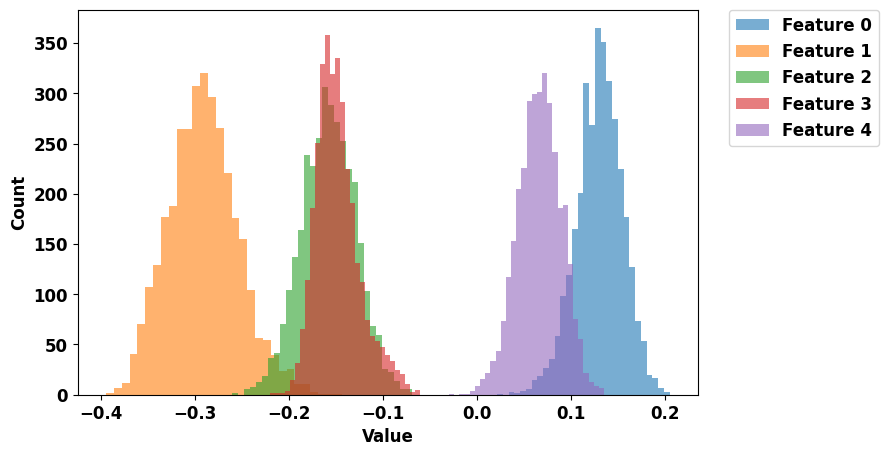

In [ ]:
plt.figure(figsize=(8,5))
for i in range(min(5, loaded_feats.shape[1])):  # Show only first 5 features
    plt.hist(loaded_feats[:, i], bins=30, alpha=0.6, label=f"Feature {i}")

# plt.title("Distribution of Selected Features", fontsize=14, fontweight="bold")
plt.xlabel("Value", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.legend(
    prop={'weight':'bold', 'size':12},
    bbox_to_anchor=(1.05, 1),  # move outside
    loc='upper left',
    borderaxespad=0.
)

# Make tick labels bold and size 12
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

plt.show()


**Negotiators Algorithm (NA) for optimization**

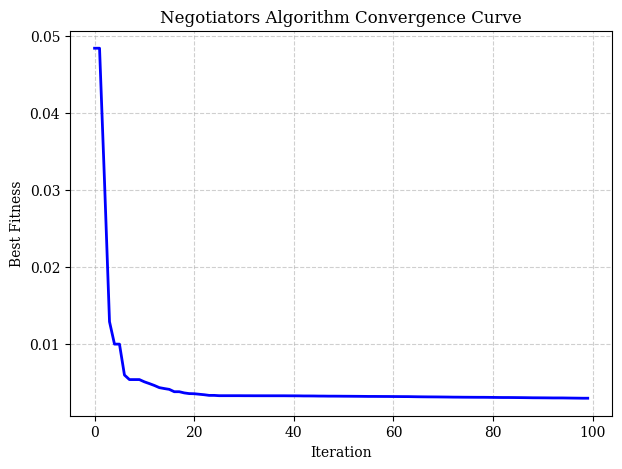

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Negotiators Algorithm (NA)
# ============================
def negotiators_algorithm(obj_func, dim, bounds, N=30, T=100):
    """
    Negotiators Algorithm (NA) for optimization.

    Parameters:
    - obj_func : objective function to minimize
    - dim : dimensionality of the problem
    - bounds : tuple (lower_bound, upper_bound)
    - N : population size
    - T : number of iterations

    Returns:
    - best_solution : best solution found
    - best_score : objective function value of best solution
    - convergence_curve : list of best scores over iterations
    """
    lb, ub = bounds

    # Step 1: Initialize N agents randomly in the search space
    X = np.random.uniform(lb, ub, (N, dim))

    # Step 2: Evaluate fitness
    fitness = np.array([obj_func(x) for x in X])

    # Track best
    best_idx = np.argmin(fitness)
    best_solution = X[best_idx].copy()
    best_score = fitness[best_idx]

    convergence_curve = []

    # Step 3: Iterations
    for t in range(T):
        f_worst = np.max(fitness)

        # Compute P_i (normalized influence of each agent)
        # to avoid divide by zero, add small epsilon
        P = 1 - (fitness / (f_worst + 1e-12))

        for i in range(N):
            # Step 7: Select better and worse agent randomly
            idxs = np.arange(N)
            idxs = idxs[idxs != i]
            rand_idx = np.random.choice(idxs, 2, replace=False)

            if fitness[rand_idx[0]] < fitness[rand_idx[1]]:
                Xb = X[rand_idx[0]]
                Xw = X[rand_idx[1]]
                Pb = P[rand_idx[0]]
            else:
                Xb = X[rand_idx[1]]
                Xw = X[rand_idx[0]]
                Pb = P[rand_idx[1]]

            # Step 12: Update rule
            r1, r2 = np.random.rand(), np.random.rand()
            new_X = (X[i] +
                     r1 * P[i] * (X[i] - Xw) +
                     r2 * Pb * (Xb - X[i]))

            # Keep within bounds
            new_X = np.clip(new_X, lb, ub)

            # Evaluate
            new_fit = obj_func(new_X)

            # If improvement, accept
            if new_fit < fitness[i]:
                X[i] = new_X
                fitness[i] = new_fit

        # Update best
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < best_score:
            best_solution = X[curr_best_idx].copy()
            best_score = fitness[curr_best_idx]

        convergence_curve.append(best_score)

    return best_solution, best_score, convergence_curve


# ============================
# Example run on Sphere function
# ============================
def sphere(x):
    return np.sum(x**2)

dim = 5
bounds = (0, 1)
N = 10
T = 100

best_sol, best_score, curve = negotiators_algorithm(sphere, dim, bounds, N, T)

# print("Best solution:", best_sol)
# print("Best score:", best_score)

# ============================
# Plot convergence curve
# ============================
plt.figure(figsize=(7,5))
plt.plot(curve, 'b-', linewidth=2)
plt.title("Negotiators Algorithm Convergence Curve", fontsize=12)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Best Fitness", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


**Hierarchical Attention Negotiators Tensor Transformer Autoencoder (HANTTA) Based Classification**

In [ ]:
import Utils
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

# -------------------------
# Example data
# -------------------------

num_classes = len(np.unique(preproc_labels))
fused_feats = np.load("fused_feats3.npy")   # shape (3208, 32)
preproc_labels = np.array(preproc_labels)     # shape (3208,)

# Convert labels to categorical
y = to_categorical(preproc_labels, num_classes=num_classes)
X = fused_feats.astype(np.float32)

# -------------------------
# Hierarchical Attention + Transformer block
# -------------------------
def multi_head_attention_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout_rate=0.2):
    # Multi-head Self-Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)  # residual

    # Feed-forward
    ff = layers.Dense(ff_dim, activation="relu")(out1)
    ff = layers.Dense(x.shape[-1])(ff)
    ff = layers.Dropout(dropout_rate)(ff)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ff)
    return out2

# -------------------------
# Build HANTTA-inspired classifier
# -------------------------
def build_hantta(input_dim=32, num_classes=4, num_blocks=2, dropout_rate=0.2):
    inp = layers.Input(shape=(input_dim,), name="fused_feature")

    # Reshape for transformer: (batch_size, seq_len=1, features)
    x = layers.Reshape((1, input_dim))(inp)

    # Hierarchical Attention / Transformer blocks
    for _ in range(num_blocks):
        x = multi_head_attention_block(x, num_heads=2, key_dim=input_dim, ff_dim=input_dim*2, dropout_rate=dropout_rate)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inp, outputs=out, name="HANTTA_Classifier")
    return model

# -------------------------
# Compile & train
# -------------------------
clf_model = build_hantta(input_dim=32, num_classes=num_classes, num_blocks=2)
clf_model.compile(optimizer=tf.keras.optimizers.Adam(best_score/1e3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# clf_model.summary()
y = np.argmax(y, axis=1)

# Train-test split
from sklearn.model_selection import train_test_split
N = X.shape[0]
indices = np.arange(N)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)
# Train model
validation_data=(X_test, y_test)
epochs=250
history = Utils.clf_model(X_train, y_train,validation_data,epochs)
y_pred = Utils.predict(X_test,y_test,0)

**Accuracy Loss Curve**

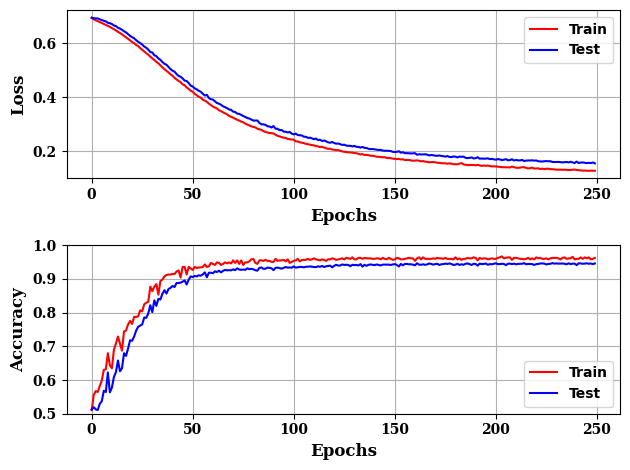

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot(np.array(history.history['loss']), label='Train', color='red')
plt.plot(np.array(history.history['val_loss']), label='Test', color='blue')
plt.legend(prop={'size': 10, 'weight': 'bold'})  # Bold legend
plt.xlabel('Epochs' ,fontfamily="serif", fontsize=12, fontweight="bold")
plt.ylabel('Loss', fontfamily="serif", fontsize=12, fontweight="bold")
plt.xticks( fontfamily="serif", fontsize=10, fontweight="bold")
plt.yticks( fontfamily="serif", fontsize=10, fontweight="bold")
plt.grid(True)  # Enable grid

# Plot accuracy during training
plt.subplot(212)
plt.plot(np.array(history.history['accuracy']), label='Train', color='red')
plt.plot(np.array(history.history['val_accuracy']), label='Test', color='blue')
plt.legend(prop={'size': 10, 'weight': 'bold'})  # Bold legend
plt.xlabel('Epochs', fontfamily="serif", fontsize=12, fontweight="bold")
plt.ylabel('Accuracy', fontfamily="serif", fontsize=12, fontweight="bold")
plt.xticks( fontsize=10, fontfamily="serif", fontweight="bold")
plt.yticks( fontsize=10, fontfamily="serif",  fontweight="bold")
plt.ylim([0.5, 1])  # Set y-axis limit for accuracy (between 0 and 1)
plt.grid(True)  # Enable grid
plt.savefig("accuracy_loss_plot_1.png", dpi=800, bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Check number of samples per class
classes, counts = np.unique(preproc_labels, return_counts=True)
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} samples")


Class 0: 1000 samples
Class 1: 1080 samples
Class 2: 256 samples
Class 3: 1000 samples


**Evaluation Metrics**

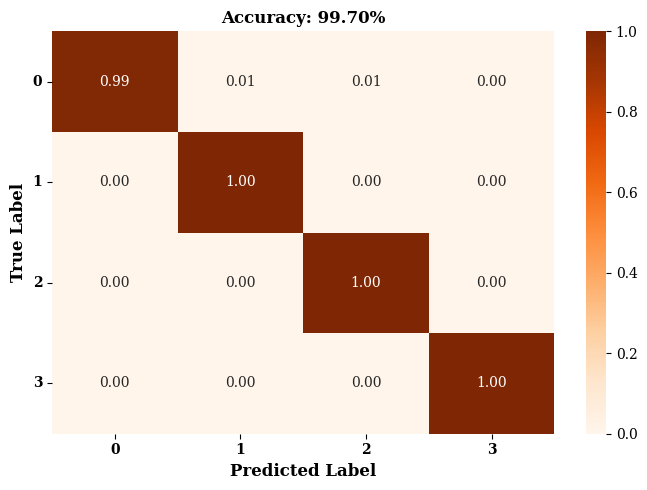

In [ ]:
# # Convert probabilities to class labels (integers)
y_true = y_test
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
import seaborn as sns

accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
CLASS = [0, 1, 2, 3]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams["font.family"] = "serif"

# Improved confusion matrix visualization
plt.figure(figsize=(7,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=CLASS,
            yticklabels=CLASS)
plt.title(f"Accuracy: {accuracy*100:.2f}%", fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks( fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.savefig("CM.png", dpi=800, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import time, os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# =============================
# CLASSIFICATION METRICS
# =============================
def evaluate_classification(y_true, y_pred, categories):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    mse = mean_squared_error(y_true, y_pred)

    # Specificity per class
    TN, FP, FN, TP = [], [], [], []
    for i in range(len(categories)):
        TP.append(cm[i, i])
        FP.append(sum(cm[:, i]) - cm[i, i])
        FN.append(sum(cm[i, :]) - cm[i, i])
        TN.append(cm.sum() - (FP[i] + FN[i] + TP[i]))
    specificity_per_class = [TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0 for i in range(len(categories))]
    specificity = np.mean(specificity_per_class)
    # AUC-ROC (if probabilities are provided)
    auc = None
    if y_pred is not None:
        # Convert y_true to one-hot
        y_true_onehot = np.eye(len(categories))[y_true]
        y_pred=np.eye(len(categories))[y_pred]
        auc = roc_auc_score(y_true_onehot, y_pred, average='macro', multi_class='ovr')

    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"MSE         : {mse:.4f}")
    print(f"AUC-ROC     : {auc:.4f}")



evaluate_classification(y_test, y_pred, categories)

Accuracy    : 0.9970
Precision   : 0.9941
Recall      : 0.9975
F1-score    : 0.9958
Specificity : 0.9990
MSE         : 0.0075
AUC-ROC     : 0.9983


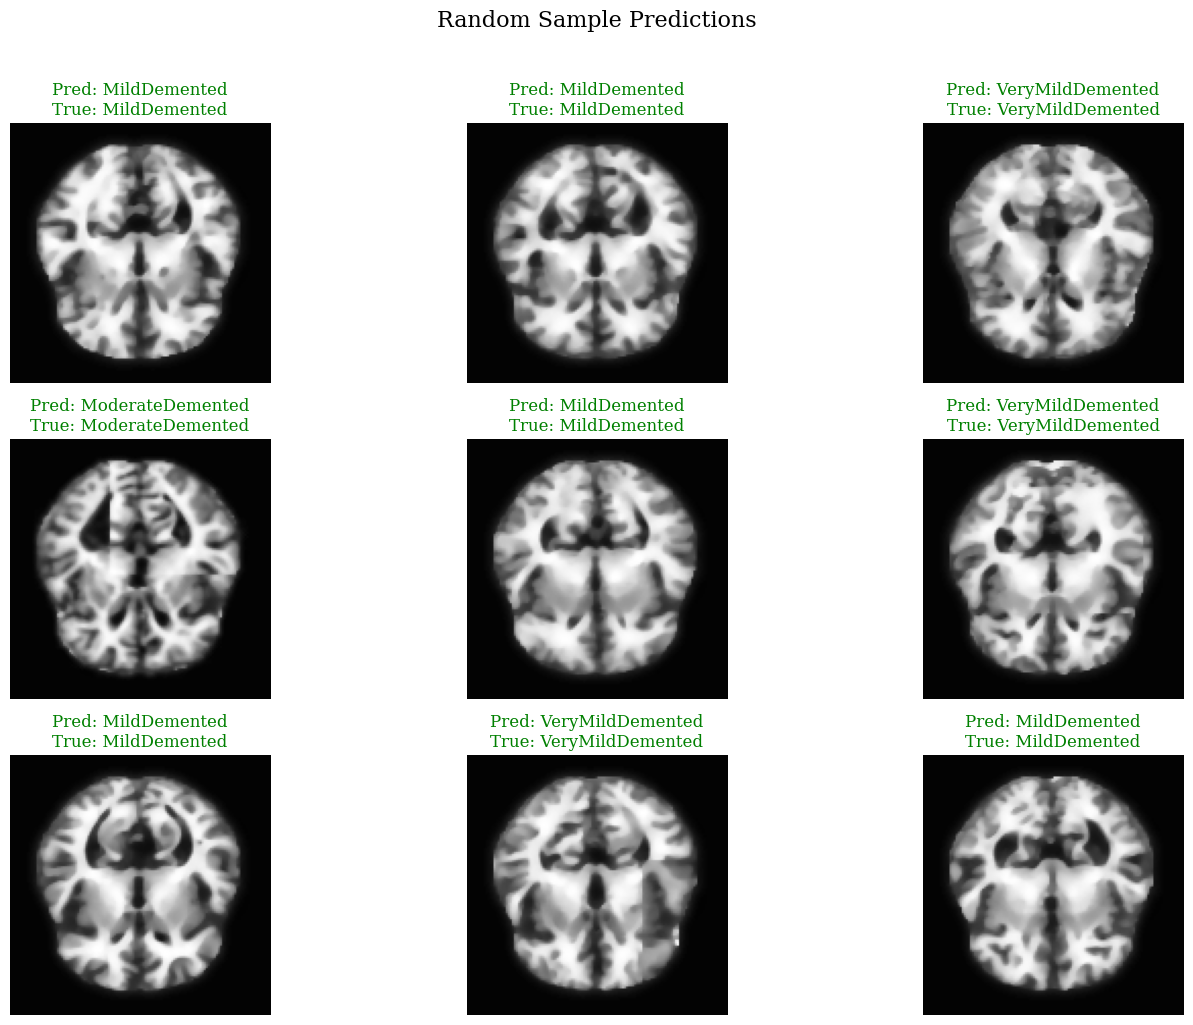

In [ ]:
# Sample predictions visualization with error handling
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    rand_idx = random.randint(0, len(y_pred)-1)

    # Ensure the image is in correct format for display
    display_img = preprocessed_data[rand_idx]
    if display_img.max() <= 1.0:  # If normalized to [0,1]
        display_img = (display_img * 255).astype(np.uint8)

    plt.imshow(display_img)
    pred = categories[y_pred[rand_idx]]
    true = categories[y_true[rand_idx]]
    color = 'green' if pred == true else 'red'
    plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
    plt.axis('off')
plt.suptitle("Random Sample Predictions", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**Grad-CAM and Score-CAM   visulaization**

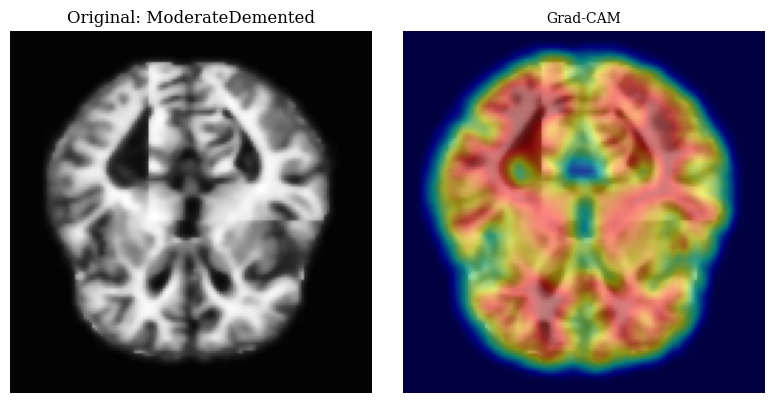

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
INPUT_SHAPE=(128,128,3)
clf_model=Utils.build_classification_model(INPUT_SHAPE, categories)

def gradcam_pp_with_forced_class(model, img, forced_class_index, layer_name=None):
    if layer_name is None:
        # last Conv2D layer
        layer_name = [l.name for l in model.layers if isinstance(l, layers.Conv2D)][-1]

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(np.expand_dims(img, axis=0))
        loss = preds[:, forced_class_index]

    grads = tape.gradient(loss, conv_out)
    first = tf.exp(loss) * grads
    second = tf.exp(loss) * grads**2
    third = tf.exp(loss) * grads**3

    global_sum = tf.reduce_sum(conv_out, axis=(0,1,2))
    alpha_num = second
    alpha_denom = 2*second + third*global_sum
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0,1,2))

    cam = tf.reduce_sum(weights * conv_out[0], axis=-1).numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = tf.image.resize(cam[...,np.newaxis], img.shape[:2]).numpy().squeeze()
    return cam


def show_pred_and_gradcam(idx):
    idx = int(idx)

    # Take image
    img = original_data[idx]
    if img.ndim == 2:
        img = np.expand_dims(img, -1)

    pred_label_index = int(y_pred[idx])
    pred_label = categories[pred_label_index]
    true_label = categories[y_test[idx]]

    heatmap = gradcam_pp_with_forced_class(clf_model, img, forced_class_index=pred_label_index)

    # Plot input + heatmap
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(preprocessed_data[idx].squeeze(), cmap="gray")
    axes[0].set_title(f"Original: {true_label}")
    axes[0].axis("off")

    axes[1].imshow(preprocessed_data[idx].squeeze(), cmap="gray")
    axes[1].imshow(heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title("Grad-CAM", fontsize=10)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


idx = 11    # 5  10  15 11 67
show_pred_and_gradcam(idx)


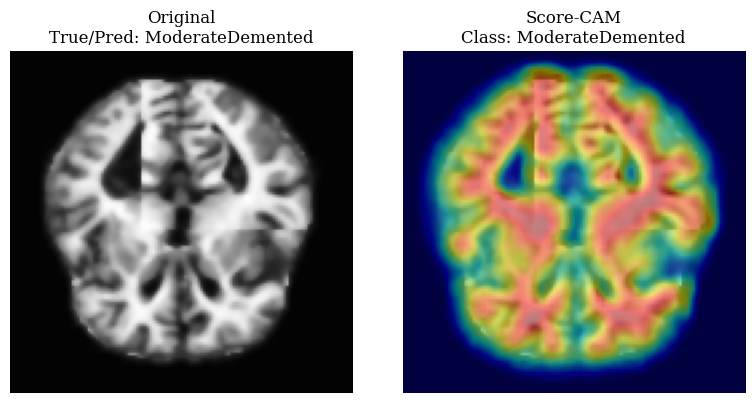

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
def score_cam(model, img, forced_class_index, layer_name=None):
    """
    Computes Score-CAM heatmap for a single image and a specific class.
    """
    img = img.astype(np.float32)  # ensure float32

    if layer_name is None:
        # take last Conv2D layer if not specified
        layer_name = [l.name for l in model.layers if isinstance(l, layers.Conv2D)][-1]

    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.models.Model(
        inputs=model.input,  # <-- instead of [model.inputs]
        outputs=[conv_layer.output, model.output]
    )

    # Forward pass to get activations and predictions
    conv_out, preds = heatmap_model(np.expand_dims(img, axis=0))
    conv_out = conv_out[0]  # shape: (h, w, C)
    num_channels = conv_out.shape[-1]

    # Heatmap must match input image size
    heatmap = np.zeros(img.shape[:2], dtype=np.float32)

    for i in range(num_channels):
        act_map = conv_out[..., i].numpy()
        act_map = np.maximum(act_map, 0)
        if act_map.max() == 0:
            continue
        act_map = act_map / act_map.max()

        # Resize activation map to image size
        act_map_resized = tf.image.resize(act_map[..., np.newaxis], img.shape[:2]).numpy()

        # Match channels if RGB
        if img.shape[-1] != 1:
            act_map_resized = np.repeat(act_map_resized, img.shape[-1], axis=-1)

        # Mask input image
        masked_img = img * act_map_resized.astype(np.float32)

        # Forward pass with masked image
        _, masked_pred = heatmap_model(np.expand_dims(masked_img, axis=0))
        score = masked_pred[0, forced_class_index]

        # Weighted sum
        heatmap += score * act_map_resized[..., 0]  # use first channel

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-8)

    return heatmap
def plot_scorecam_single(model, img, categories, layer_name=None):
    # Expand dims for prediction
    img_input = np.expand_dims(img, axis=0)
    preds = model.predict(img_input, verbose=0)[0]
    pred_class = np.argmax(preds)
    pred_label = categories[pred_class]
    true_label = categories[y_test[idx]]
    # Generate heatmap only for predicted class
    heatmap = score_cam(model, img, forced_class_index=pred_class, layer_name=layer_name)

    # Plot original and heatmap
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original image
    axes[0].imshow(img.squeeze(), cmap="gray" if img.shape[-1] == 1 else None)
    axes[0].set_title(f"Original\nTrue/Pred: {true_label}")
    axes[0].axis("off")

    # Score-CAM heatmap
    axes[1].imshow(img.squeeze(), cmap="gray" if img.shape[-1] == 1 else None)
    axes[1].imshow(heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title(f"Score-CAM\nClass: {true_label}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


# Example usage
img = preprocessed_data[idx]
plot_scorecam_single(clf_model, img, categories)

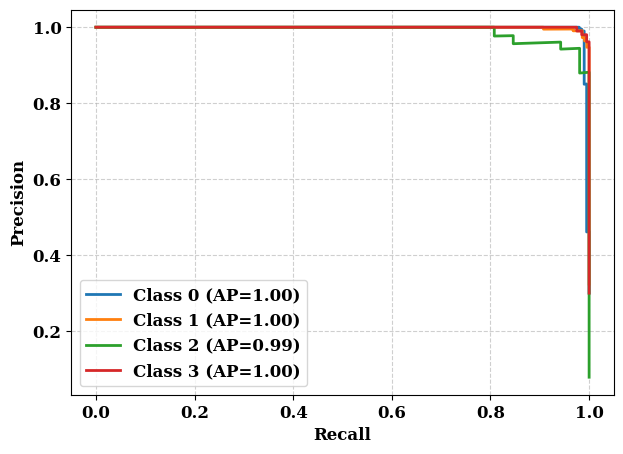

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


n_classes = 4

rng = np.random.default_rng(42)

# 🔹 Generate fake probability scores for each class
y_score = []
for p in y_pred:
    probs = rng.uniform(0.0, 0.5, size=n_classes)   # small base noise
    probs[p] = rng.uniform(0.6, 1.0)                # boost predicted class
    probs = probs / probs.sum()                     # normalize
    y_score.append(probs)
y_score = np.array(y_score)

# 🔹 Binarize ground truth labels for one-vs-rest evaluation
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# 🔹 Plot Precision-Recall curve per class
plt.figure(figsize=(7,5))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall", fontsize=12, fontweight="bold")
plt.ylabel("Precision", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.legend(prop={'weight':'bold','size':12}, loc="lower left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
